# MNIST with SciKit-Learn and SKORCH

This notebook shows how to define and train a simple Neural-Network with PyTorch and use it via skorch with SciKit-Learn.

**Tuned  by SB 
(21.10.26)**: adding **a validation set to estimate the values of the learning rate (lr) and the number of epochs (max_epochs)**. In this way, the results are experimentally much more robust from a statistical point of view and even better than those of the original code. In particular, the **error improvements achieved using a NN and a CNN can be up to 50% and 100% respectively compared to those obtained in the original code** (<a target="_blank" href="https://github.com/skorch-dev/skorch/blob/master/notebooks/MNIST.ipynb"><img width=16px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td></table>). 
**(22.10.19)**: adding comments and variables at different points of the code to compute the learning curves. 
**(22.10.31)**: modifying how to install Python packages using specific versions and how data is loaded in block 3 (adding condition as_frame=False). 

<table align="left"><td>
<a target="_blank" href="https://colab.research.google.com/github/skorch-dev/skorch/blob/master/notebooks/MNIST.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run this code in Google Colab</a>  
</td><td>

*Successfully tested for Python 3.7.15, torch 1.12.1+cu113, scikit-learn 1.0.2 and skorch 0.12.0.* 


**Note**: If you are running this in [a colab notebook](https://colab.research.google.com/github/skorch-dev/skorch/blob/master/notebooks/MNIST.ipynb), we recommend you enable a free GPU by going:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**


After installing the Python packages (execution of code block in cell#1) or running the code some time changing params (e.g. affecting array sizes, etc.), consider restarting to avoid runtime errors via:

> **Runtime**   →   **Restart and run all**  

or

> **Runtime**   →   **Restart runtime**   (CRTL+M)  and

> **Runtime**   →   **Run all** (CTRL+F9)

If runtime errors persist consider restarting completely via:   
> **Runtime**   →   **Disconnect and delete run time**

(If you are running in colab, you should install the dependencies and download the dataset by running cells #1-4.)

To change the language in Colab to English, reopen the script by appending '*?hl=en*' to the end of its Internet address or goto menu *Ayuda->Ver en inglés* if Spanish is the default language. 

In [ ]:
! [ ! -z "$COLAB_GPU" ] 
!pip install torch==1.12.1+cu113 
!pip install scikit-learn==1.0.2
!pip install skorch==0.12.0  
!python --version
#!pip list

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 185 kB 14.3 MB/s 
Python 3.7.15


In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

## Loading Data
Using SciKit-Learns ```fetch_openml``` to load MNIST data.

In [ ]:
mnist = fetch_openml('mnist_784', as_frame=False, cache=False)

In [ ]:
mnist.data.shape  # number of samples, input dimension 

(70000, 784)

## Preprocessing Data

Each image of the MNIST dataset is encoded in a 784 dimensional vector, representing a 28 x 28 pixel image. Each pixel has a value between 0 and 255, corresponding to the grey-value of a pixel.<br />
The above ```featch_mldata``` method to load MNIST returns ```data``` and ```target``` as ```uint8``` which we convert to ```float32``` and ```int64``` respectively.

In [ ]:
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')

To avoid big weights that deal with the pixel values from between [0, 255], we scale `X` down. A commonly used range is [0, 1].

In [ ]:
X /= 255.0

In [ ]:
X.min(), X.max()

(0.0, 1.0)

Note: data is not normalized.

In [ ]:
# The default partition of the MNIST database is: MNIST(100%) = tr(50%)+ val(25%) + tst(25%).
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.5, random_state=42)        # tr(50%), val+tst(50%)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)  # val(25%), tst(25%)

# A suggested partition of the MNIST database is: MNIST(100%) = tr(70%)+ val(15%) + tst(15%).
#X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.3, random_state=42)        # tr(70%), val+tst(30%)
#X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)  # val(15%), tst(15%)

In [ ]:
assert(X_train.shape[0] + X_val_test.shape[0] == mnist.data.shape[0])

In [ ]:
X_train.shape, y_train.shape

((35000, 784), (35000,))

### Print a selection of training images and their labels

In [ ]:
def plot_example(X, y):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[:5].reshape(5, 28, 28), y[:5])):
        plt.subplot(151 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y)

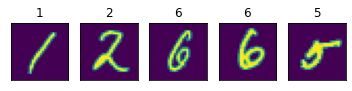

In [ ]:
plot_example(X_train, y_train)

## Build Neural Network with PyTorch
Simple, fully connected neural network with one hidden layer. Input layer has 784 dimensions (28x28), hidden layer has 98 (= 784 / 8) by default and output layer 10 neurons, representing digits 0 - 9.

**HINT:** To obtain the learning curves of the neural network (that is, the training, validation and test errors with respect to the number of neurons in the hidden layer), modify the *hidden_dim* variable by setting different values.  To do this, write down the value of the variables *train_acc*, *val_acc* and *test_acc* obtained by the network for each of the values of hidden_dim tested. Repeat the process for different partitions of the training, validation and test sets; the default partition is: tr(50%), val(25%) and tst(25%).

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
mnist_dim = X.shape[1]
hidden_dim = int(mnist_dim/8)
output_dim = len(np.unique(mnist.target))

In [ ]:
mnist_dim, hidden_dim, output_dim

(784, 98, 10)

A Neural network in PyTorch's framework.

In [ ]:
class ClassifierModule(nn.Module):
    def __init__(
            self,
            input_dim=mnist_dim,
            hidden_dim=hidden_dim,
            output_dim=output_dim,
            dropout=0.5,
    ):
        super(ClassifierModule, self).__init__()
        self.dropout = nn.Dropout(dropout)

        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)

    def forward(self, X, **kwargs):
        X = F.relu(self.hidden(X))
        X = self.dropout(X)
        X = F.softmax(self.output(X), dim=-1)
        return X

SKORCH allows to use PyTorch's networks in the SciKit-Learn setting:

In [ ]:
from skorch import NeuralNetClassifier

In [ ]:
torch.manual_seed(0)

net = NeuralNetClassifier(
    ClassifierModule,
    max_epochs=40,
    lr=0.1,
    device=device,
)

In [ ]:
net.fit(X_train, y_train);
from sklearn.metrics import accuracy_score
y_train_pred = net.predict(X_train);
train_acc=accuracy_score(y_train, y_train_pred);
print(f'Training accuracy: {train_acc:.6f}');    # use this value for the training learning curve
y_val_pred = net.predict(X_val);
val_acc=accuracy_score(y_val, y_val_pred);
print(f'Validation accuracy: {val_acc:.6f}');   # use this value for the validation learning curve

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.9813       0.8791        0.4486  4.6774
      2        0.4931       0.9013        0.3499  1.0560
      3        0.4075       0.9113        0.3041  1.0995
      4        0.3661       0.9203        0.2727  1.4000
      5        0.3336       0.9254        0.2511  1.0409
      6        0.3096       0.9303        0.2365  1.2933
      7        0.2885       0.9334        0.2192  0.5872
      8        0.2812       0.9363        0.2098  0.5674
      9        0.2664       0.9387        0.2030  0.5655
     10        0.2549       0.9424        0.1930  0.5708
     11        0.2400       0.9437        0.1866  0.5747
     12        0.2365       0.9454        0.1793  0.5799
     13        0.2291       0.9444        0.1733  0.5829
     14        0.2219       0.9470        0.1701  0.5718
     15        0.2153       0.9466        0.1666  0.5879
     16        0.2078       0.9

## Prediction

In [ ]:
#from sklearn.metrics import accuracy_score

In [ ]:
y_pred = net.predict(X_test)

In [ ]:
test_acc= accuracy_score(y_test, y_pred);
print(f'An accuracy of about {test_acc*100:.2f}% for a network with only one hidden layer is not too bad. ');

An accuracy of about 96.38% for a network with only one hidden layer is not too bad. 


Let's take a look at some predictions that went wrong:

In [ ]:
error_mask = y_pred != y_test

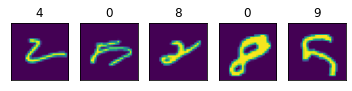

In [ ]:
plot_example(X_test[error_mask], y_pred[error_mask])

# Convolutional Network (LeNet)
PyTorch expects a 4 dimensional tensor as input for its 2D convolution layer. The dimensions represent:
* Batch size
* Number of channel
* Height
* Width

As initial batch size the number of examples needs to be provided. MNIST data has only one channel. As stated above, each MNIST vector represents a 28x28 pixel image. Hence, the resulting shape for PyTorch tensor needs to be (x, 1, 28, 28). 

In [ ]:
XCnn = X.reshape(-1, 1, 28, 28)

In [ ]:
XCnn.shape

(70000, 1, 28, 28)

In [ ]:
# The default partition of the MNIST database is: MNIST(100%) = tr(50%)+ val(25%) + tst(25%).
XCnn_train, XCnn_val_test, y_train, y_val_test = train_test_split(XCnn, y, test_size=0.5, random_state=42)
XCnn_val, XCnn_test, y_val_cnn, y_test = train_test_split(XCnn_val_test, y_val_test, test_size=0.5, random_state=42)

In [ ]:
XCnn_train.shape, y_train.shape

((35000, 1, 28, 28), (35000,))

In [ ]:
#  To obtain the learning curves, modify the neurons that interconnect two of 
#  the last layers of LeNet (neurons_fc12):
#
neurons_fc12=100
#    

class Cnn(nn.Module):
    def __init__(self, dropout=0.5):
        super(Cnn, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv2_drop = nn.Dropout2d(p=dropout)
        self.fc1 = nn.Linear(1600, neurons_fc12) # 1600 = number channels * width * height
        self.fc2 = nn.Linear(neurons_fc12, 10)
        self.fc1_drop = nn.Dropout(p=dropout)

    def forward(self, x):
        x = torch.relu(F.max_pool2d(self.conv1(x), 2))
        x = torch.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        
        # flatten over channel, height and width = 1600
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))
        
        x = torch.relu(self.fc1_drop(self.fc1(x)))
        x = torch.softmax(self.fc2(x), dim=-1)
        return x

In [ ]:
torch.manual_seed(0)

cnn = NeuralNetClassifier(
    Cnn,
    max_epochs=10,
    lr=0.002,
    optimizer=torch.optim.Adam,
    device=device,
)

In [ ]:
cnn.fit(XCnn_train, y_train);
y_train_pred_cnn = cnn.predict(XCnn_train);
train_acc_cnn=accuracy_score(y_train, y_train_pred_cnn);
print(f'Training accuracy: {train_acc_cnn:.6f}');    # use this value for the training learning curve
y_val_pred_cnn = cnn.predict(XCnn_val);
val_acc_cnn=accuracy_score(y_val_cnn, y_val_pred_cnn);
print(f'Validation accuracy: {val_acc_cnn:.6f}');    # use this value for the validation learning curve

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6230       0.9606        0.1294  5.6525
      2        0.2309       0.9734        0.0863  0.9936
      3        0.1795       0.9796        0.0653  0.9915
      4        0.1511       0.9811        0.0606  0.9864
      5        0.1421       0.9827        0.0530  0.9794
      6        0.1261       0.9850        0.0521  0.9790
      7        0.1249       0.9860        0.0466  0.9947
      8        0.1119       0.9859        0.0464  0.9779
      9        0.1032       0.9867        0.0444  0.9827
     10        0.0994       0.9880        0.0425  0.9745
Training accuracy: 0.991143
Validation accuracy: 0.985771


In [ ]:
y_pred_cnn = cnn.predict(XCnn_test)

In [ ]:
accuracy_score(y_test, y_pred_cnn)

0.9855428571428572

An accuracy of >98% should suffice for this example!

Let's see how we fare on the examples that went wrong before:

In [ ]:
acc_improvement=accuracy_score(y_test[error_mask], y_pred_cnn[error_mask]);
print(f'Over {acc_improvement*100:.2f}% of the previously misclassified images are now correctly identified.');

Over 69.72% of the previously misclassified images are now correctly identified.


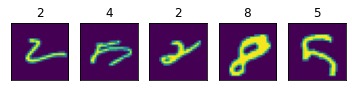

In [ ]:
plot_example(X_test[error_mask], y_pred_cnn[error_mask])